In [1]:
# Python version: 3.10.6
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

# 1 - Data processing

In [2]:
# Training set features (X) and labels (y)
df_X = pd.read_csv("data/train_values.csv", on_bad_lines="skip", sep=",", header=0)
df_y = pd.read_csv("data/train_labels.csv", on_bad_lines="skip", sep=",", header=0)

# Convert labels to 0, 1, 2 for xgboost classifier
df_y2 = df_y.copy()
df_y2.loc[df_y2.damage_grade == 1, "damage_grade"] = 0
df_y2.loc[df_y2.damage_grade == 2, "damage_grade"] = 1
df_y2.loc[df_y2.damage_grade == 3, "damage_grade"] = 2

# dataframe for test set features
df_X_test = pd.read_csv("data/test_values.csv", on_bad_lines="skip", sep=",", header=0)

In [3]:
df_X

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_y2

,building_id,damage_grade
0,802906,2
1,28830,1
2,94947,2
3,590882,1
4,201944,2
...,...,...
260596,688636,1
260597,669485,2
260598,602512,2
260599,151409,1


## 1.1 - Normalize numerical features
Numerical features:
- geo_level_1_id,
- geo_level_2_id,
- geo_level_3_id,
- count_floors_pre_eq,
- age,
- area_percentage,
- height_percentage,
-  count_families

Output: dataframes of normalized features

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

# Train set
X_unscaled = df_X.loc[:, ["geo_level_1_id","geo_level_2_id","geo_level_3_id",
                               "count_floors_pre_eq","age","area_percentage",
                               "height_percentage", "count_families"]]

X_normalized = pd.DataFrame(min_max_scaler.fit_transform(X_unscaled), columns=X_unscaled.columns)
print(X_normalized)


# Test set
X_unscaled_test = df_X_test.loc[:, ["geo_level_1_id","geo_level_2_id","geo_level_3_id",
                               "count_floors_pre_eq","age","area_percentage",
                               "height_percentage", "count_families"]]

X_normalized_test = pd.DataFrame(min_max_scaler.fit_transform(X_unscaled_test), columns=X_unscaled_test.columns)
print(X_normalized_test)

## 1.2 - Apply one-hot encoding to categorical features
Categorical features:
- land_surface_condition
- foundation_type
- roof_type
- ground_floor_type
- other_floor_type
- position
- plan_configuration
- legal_ownership_status

Output: dataframes of one-hot encoded features

In [ ]:
# Train set:
X_cat = df_X.loc[:, ["land_surface_condition", "foundation_type", "roof_type",
                        "ground_floor_type", "other_floor_type", "position",
                        "plan_configuration", "legal_ownership_status"]]     # 8 features
X_cat = pd.get_dummies(X_cat,
                          columns=["land_surface_condition", "foundation_type", "roof_type",
                                   "ground_floor_type", "other_floor_type", "position",
                                   "plan_configuration", "legal_ownership_status"],
                            sparse=True,
                            dtype=int)  # Get SPARSE MATRIX VIA get_dummies()
print(X_cat)



# Test set:
X_cat_test = df_X_test.loc[:, ["land_surface_condition", "foundation_type", "roof_type",
                        "ground_floor_type", "other_floor_type", "position",
                        "plan_configuration", "legal_ownership_status"]]     # 8 features
X_cat_test = pd.get_dummies(X_cat_test,
                          columns=["land_surface_condition", "foundation_type", "roof_type",
                                   "ground_floor_type", "other_floor_type", "position",
                                   "plan_configuration", "legal_ownership_status"],
                            sparse=True,
                            dtype=int)  # Get SPARSE MATRIX VIA get_dummies()
print(X_cat_test)

## 1.3 - Binary features
Any feature that are not categorical nor numerical

Output: dataframes of binary features

In [ ]:
# Train set:
X_bin = df_X.drop(["building_id", "geo_level_1_id","geo_level_2_id","geo_level_3_id",
                        "count_floors_pre_eq","age","area_percentage",
                        "height_percentage", "count_families","land_surface_condition",
                        "foundation_type",
                        "roof_type",
                        "ground_floor_type",
                        "other_floor_type",
                        "position",
                        "plan_configuration",
                        "legal_ownership_status"], axis=1)
print(X_bin)


# Test set:
X_bin_test = df_X_test.drop(["building_id", "geo_level_1_id","geo_level_2_id","geo_level_3_id",
                        "count_floors_pre_eq","age","area_percentage",
                        "height_percentage", "count_families","land_surface_condition",
                        "foundation_type",
                        "roof_type",
                        "ground_floor_type",
                        "other_floor_type",
                        "position",
                        "plan_configuration",
                        "legal_ownership_status"], axis=1)
print(X_bin_test)

## 1.4 - Reconstruct dataframe of all features that are processed
aka concatenating dataframes from 1.1, 1.2, and 1.3

In [8]:
X_train = pd.concat([X_normalized, X_bin, X_cat], axis=1)

X_test = pd.concat([X_normalized_test, X_bin_test, X_cat_test], axis=1)

## 1.5 - Split to train - dev sets

In [9]:
# Train model on these data to choose hyperparameters
train_X = X_train[: int(len(X_train) * 0.85)]
train_y = df_y[: int(len(df_y) * 0.85)].drop(["building_id"], axis=1)
train_y2 = df_y2[: int(len(df_y2) * 0.85)].drop(["building_id"], axis=1)    # for xgboost

dev_X = X_train[int(len(X_train) * 0.85 ):]
dev_y = df_y[int(len(df_y) * 0.85 ):]
dev_y2 = df_y2[int(len(df_y2) * 0.85 ):]    # for xgboost

# Train model (with chosen hyperparameters) on this non-splitted data for inference on test set 
train_X_full = X_train
train_y_full = df_y.drop(["building_id"], axis=1)
train_y_full2 = df_y2.drop(["building_id"], axis=1) # df_y2 aka 0,1,2 labels so xgclassifier can work

## 1.6 - Feature explorations

<Axes: >

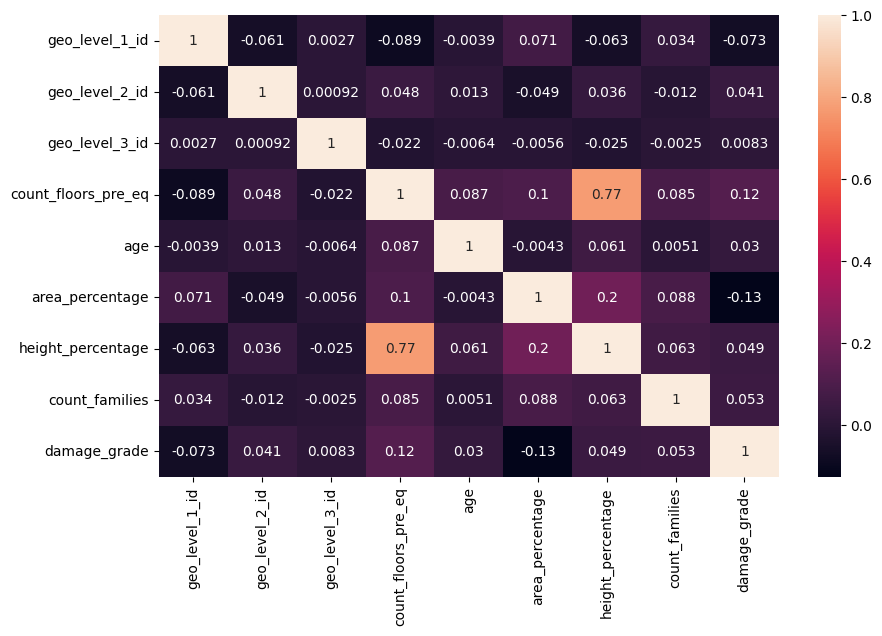

In [10]:
# Correlation among features

cor = pd.concat([X_normalized, train_y], axis=1).corr()

plt.figure(figsize=(10,6))
sns.heatmap(cor, annot=True)

# ---> Remove either height_percentage or count_floors_pre_eq

In [11]:
# Variance threshold

v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(train_X)

v_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [12]:
# Mutual information (Info gain)
importances = mutual_info_classif(train_X, train_y)

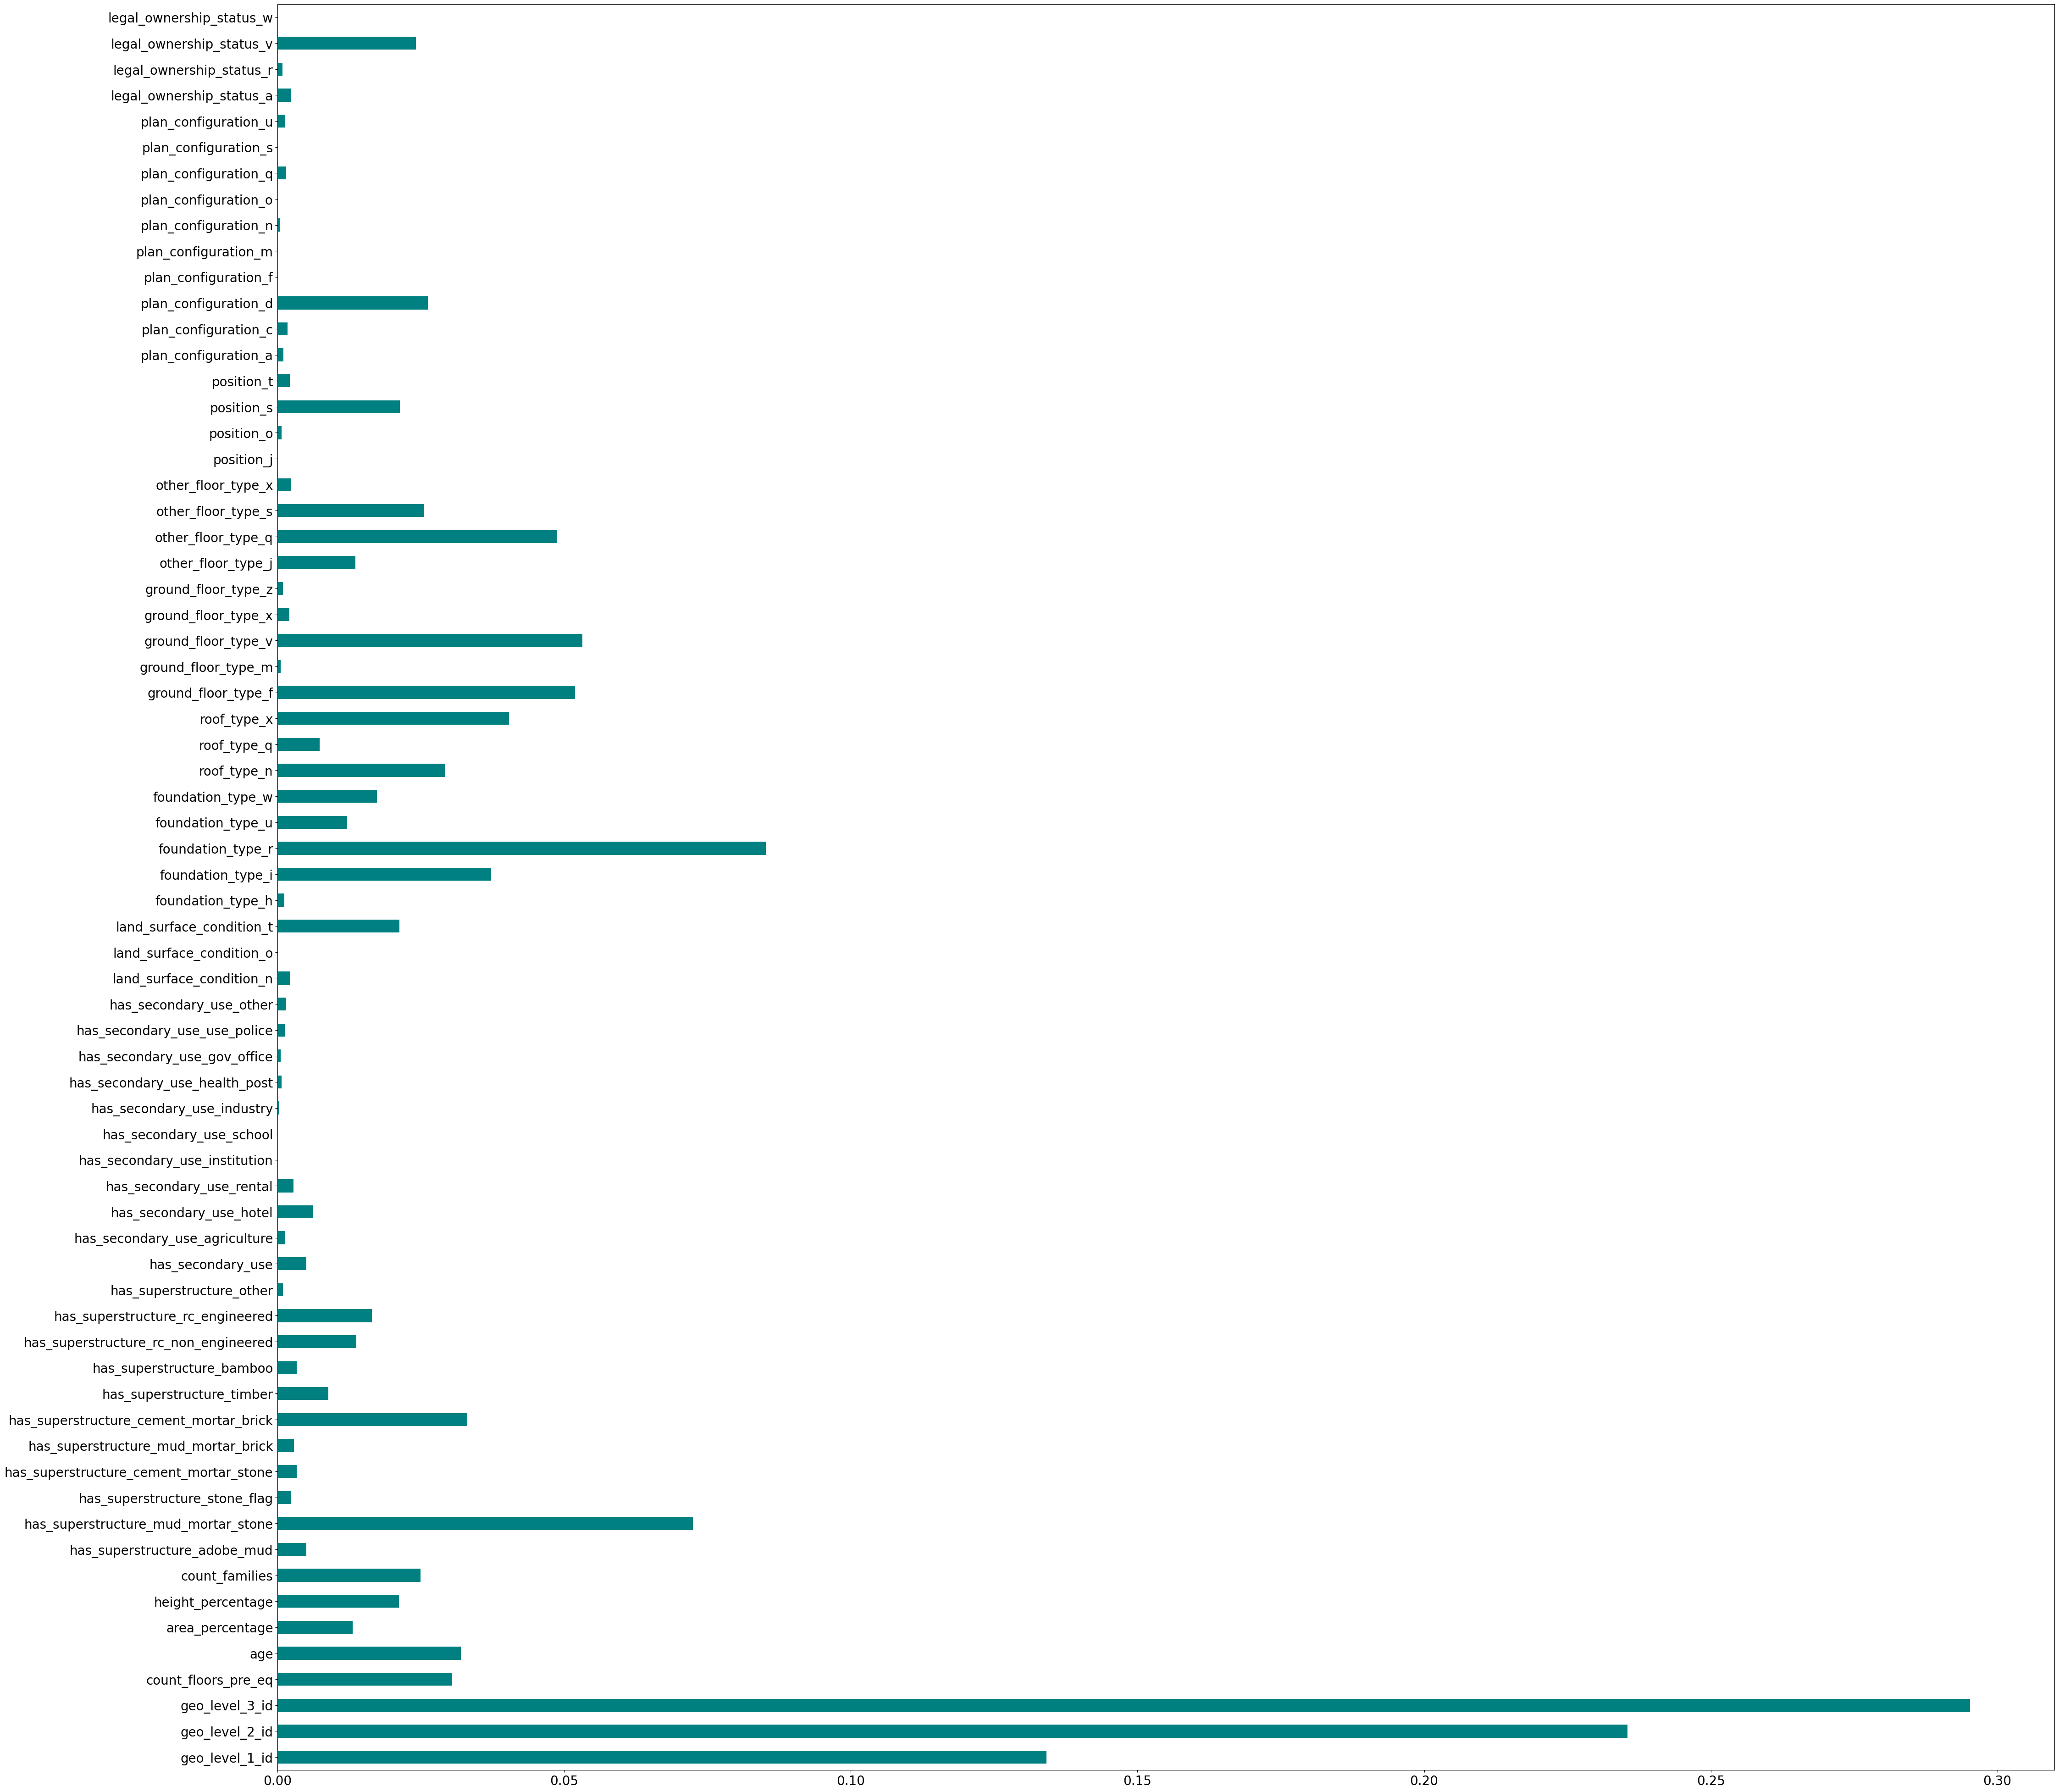

In [13]:
plt.rcParams["figure.figsize"] = (50,50)
plt.rcParams.update({'font.size': 20})

feat_importances = pd.Series(importances, train_X.columns)
feat_importances.plot(kind="barh", color="teal")

plt.show()

## 1.7 - Rebuild dataset
Drop features that has low correlation to label: 
- count_floors_pre_eq
- legal_ownership_status_w
- legal_ownership_status_r
- legal_ownership_status_a
- plan_configuration_u
- plan_configuration_s
- plan_configuration_q
- plan_configuration_o
- plan_configuration_n
- plan_configuration_m
- plan_configuration_f
- plan_configuration_c
- plan_configuration_a
- position_j
- position_o
- ground_floor_type_z
- ground_floor_type_x
- ground_floor_type_m
- roof_type_q
- foundation_type_h
- land_surface_condition_o
- land_surface_condition_n
- has_secondary_use_other
- has_secondary_use_use_police
- has_secondary_use_gov_office
- has_secondary_use_health_post
- has_secondary_use_industry
- has_secondary_use_school
- has_secondary_use_institution
- has_superstructure_other
- has_superstructure_timber
- has_superstructure_cement_mortar_stone
- count_families
    
Drop features that has high correlation with one another: either height_percentage or count_floors_pre_eq

In [14]:
# Features to be dropped:
cols = [
    "count_floors_pre_eq", "legal_ownership_status_w", "legal_ownership_status_r",
    "legal_ownership_status_a", "plan_configuration_u", "plan_configuration_s",
    "plan_configuration_q", "plan_configuration_o", "plan_configuration_n",
    "plan_configuration_m", "plan_configuration_f", "plan_configuration_c",
    "plan_configuration_a", "position_j", "position_o", "ground_floor_type_z",
    "ground_floor_type_x", "ground_floor_type_m", "roof_type_q", "foundation_type_h",
    "land_surface_condition_o", "land_surface_condition_n", "has_secondary_use_other",
    "has_secondary_use_use_police", "has_secondary_use_gov_office", "has_secondary_use_health_post",
    "has_secondary_use_industry", "has_secondary_use_school", "has_secondary_use_institution",
    "has_superstructure_other", "has_superstructure_timber", "has_superstructure_cement_mortar_stone",
    "count_families"
]


# Drop features on train-dev splits
train_X_tuned = train_X.drop(cols, axis=1)
dev_X_tuned = dev_X.drop(cols, axis=1)

# Drop features on full train data
train_X_full_tuned = train_X_full.drop(cols, axis=1)

# Drop features on test data
X_test_dropped = X_test.drop(cols, axis=1)

# 2 - Model try out

## 2.1 - Helpers

In [21]:
# Write prediction to pred.csv
def write_out(test_set, result, file_name, xgboost=False):
    final_result = []
    for i,j in zip(test_set.loc[:,["building_id"]].values, result):
        if xgboost:
            final_result.append([i[0],j+1])
        else:
            final_result.append([i[0],j])
        
    output = pd.DataFrame(final_result, columns=["building_id","damage_grade"])
    # final_result
    output.to_csv(file_name, index=False)

# Calculate F1 scores
def val_acc(dev_set, result):
    score = f1_score(dev_set["damage_grade"].values.tolist(),
                     result, average='micro')
    return score

## 2.2 - Random forest classifier

### 2.2.a - Train on dataset of all features

In [16]:
clf = RandomForestClassifier(n_estimators=101, min_samples_split=15,
                             min_samples_leaf=1, max_depth=50,
                             criterion="entropy", bootstrap=True)
clf.fit(train_X, train_y)
clf.score(train_X, train_y)

0.8450589138187892

In [17]:
result = clf.predict(dev_X).tolist()
val_acc(dev_y, result)

0.7232099460233813

### 2.2.b - Train on dataset of dropped features

In [18]:
clf2 = RandomForestClassifier(n_estimators=101, min_samples_split=15,
                             min_samples_leaf=1, max_depth=50,
                             criterion="entropy", bootstrap=True)
clf2.fit(train_X_tuned, train_y)
clf2.score(train_X_tuned, train_y)

0.8383729854182655

In [19]:
result = clf2.predict(dev_X_tuned).tolist()
val_acc(dev_y, result)

0.7226471566345195

In [22]:
result = clf2.predict(X_test_dropped).tolist()
write_out(df_X_test, result, file_name="pred-rfc.csv")

## 2.3 - Adaboost Classifier

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=101, min_samples_split=15,
#                     min_samples_leaf=1, max_depth=50,
#                     criterion="entropy", bootstrap=True)
# adab_clf = AdaBoostClassifier(n_estimators=100, base_estimator=rf_clf)
# adab_clf.fit(train_X_tuned, train_y)

# adab_clf.score(train_X_tuned, train_y)

In [23]:
# result = adab_clf.predict(dev_X_tuned)
# val_acc(dev_y, result)

## 2.4 - XGBoost Classifier

### 2.4.a - Train and validate

In [ ]:
# Train on dataset of all features
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb_clf.fit(train_X, train_y2)

In [25]:
result = xgb_clf.predict(dev_X)
val_acc(dev_y2, result)

0.7275076104474174

In [ ]:
# Train on dataset of dropped features
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb_clf.fit(train_X_tuned, train_y2)

In [27]:
result = xgb_clf.predict(dev_X_tuned)
val_acc(dev_y2, result)

0.7276099357908471

### 2.4.b - Train on full dataset for inference on test set

In [28]:
# Train on dataset of dropped features
xgb_clf = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)

xgb_clf.fit(train_X_full_tuned, train_y_full2)
print(xgb_clf.score(train_X_full_tuned, train_y_full2))

0.7430554756121427


In [29]:
result = xgb_clf.predict(X_test_dropped).tolist()
write_out(df_X_test, result, xgboost=True, file_name="pred-xgbc-untuned.csv")

# 2.5 - Finetune model with Searching techniques

## 2.5.a - Optimal hyperparameter tuning with Optuna

In [30]:
def optimize(trial):
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.25, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0),
        'eval_metric': 'auc',
        'objective': 'multi:softprob',
        'use_label_encoder': False,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'callbacks': [pruning_callback]
    }

    xgb_clf = xgb.XGBClassifier(**params)
    xgb_clf.fit(train_X_tuned, train_y2,
                eval_set=[(dev_X_tuned, dev_y2.drop(["building_id"], axis=1))],
                verbose=False)

    result = xgb_clf.predict(dev_X_tuned)
    f1_score = val_acc(dev_y2, result)

    return f1_score

study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(n_startup_trials=20))
study.optimize(optimize, n_trials=2)

[I 2023-04-07 19:35:10,637] A new study created in memory with name: no-name-f74b36bf-72ba-43df-bb3f-971e85ce9568
[I 2023-04-07 19:35:16,052] Trial 0 finished with value: 0.7334168990304674 and parameters: {'max_depth': 8, 'learning_rate': 0.9446167246411572, 'n_estimators': 218, 'min_child_weight': 1, 'gamma': 0.621913177208913, 'subsample': 0.7471416845728538, 'colsample_bytree': 0.6879426341601729, 'reg_alpha': 0.9114607777814483, 'reg_lambda': 0.10624730227536512}. Best is trial 0 with value: 0.7334168990304674.
[I 2023-04-07 19:35:23,107] Trial 1 finished with value: 0.7378680514696477 and parameters: {'max_depth': 5, 'learning_rate': 0.2892992074978003, 'n_estimators': 455, 'min_child_weight': 3, 'gamma': 0.4333262751586961, 'subsample': 0.8924852432353418, 'colsample_bytree': 0.9939812006149005, 'reg_alpha': 0.4048378155996929, 'reg_lambda': 0.21367040097241402}. Best is trial 1 with value: 0.7378680514696477.


In [31]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 2
Best trial:
  Value: 0.7378680514696477
  Params: 
    max_depth: 5
    learning_rate: 0.2892992074978003
    n_estimators: 455
    min_child_weight: 3
    gamma: 0.4333262751586961
    subsample: 0.8924852432353418
    colsample_bytree: 0.9939812006149005
    reg_alpha: 0.4048378155996929
    reg_lambda: 0.21367040097241402


In [32]:
params = trial.params
model = xgb.XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0)
model.fit(train_X_full_tuned, train_y_full2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9939812006149005, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4333262751586961, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2892992074978003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=455, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [34]:
result = model.predict(X_test_dropped).tolist()

write_out(df_X_test, result, xgboost=True, file_name="pred-xgb-tuned.csv")

## 2.5.b - Optuna + Cross-validation

## 2.5.c - Optuna + Lightgbm